# Training a U-net Model from Scratch 

# Loading The Data

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch.nn.functional import relu
import pydicom
from PIL import Image
import numpy as np
from torchsummary import summary
import torch.nn.functional as F



First, I need to make a data structure that contains pairs of an image along with its binary masks. 


In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch.nn.functional import relu
import pydicom
from PIL import Image
import numpy as np
from torchsummary import summary
import torch.nn.functional as F


In [2]:
root_dir = "mask_and_mri"

data = []  # List to store image-masks pairs

# Iterate over patient directories in mask_and_mri
for patient_dir in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_dir)
    if os.path.isdir(patient_path):
        images_dir = os.path.join(patient_path, "images")
        masks_dir = os.path.join(patient_path, "masks")
        
        # Iterate over image files
        for image_file in os.listdir(images_dir):
            if image_file.endswith(".dcm"):
                image_path = os.path.join(images_dir, image_file)
                
                # Extract image ID
                image_id = image_file[:-4]  # Remove extension
                
                # Find corresponding masks
                masks = []
                for mask_file in os.listdir(masks_dir):
                    if image_id in mask_file:
                        mask_path = os.path.join(masks_dir, mask_file)
                        # makes a one to one mapping for masks and their image
                        data.append((mask_path,image_path))
                

# Print first few entries for verification
for i in range(30):
    print(data[i])
    
print(len(data))

('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0048_icontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0048.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0059_icontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0059.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0059_ocontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0059.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0068_icontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0068.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0079_icontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0079.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0079_ocontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0079.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0088_icontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0088.dcm')
('mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0099_icontour_1_mask.png', 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0099.dcm')
('mask_a

# Visualization of a single image with a mask

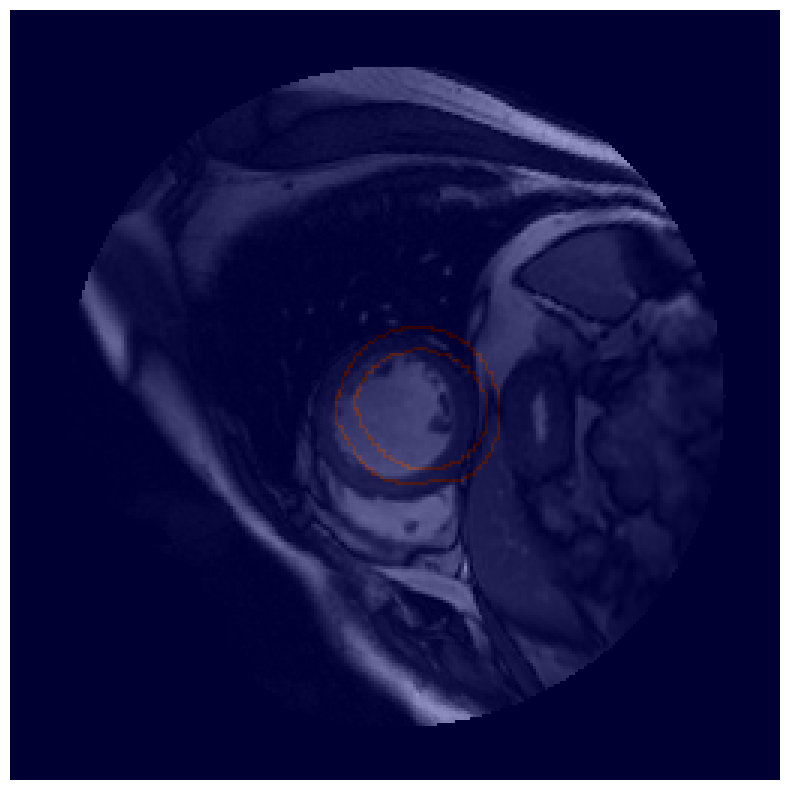

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# images and masks will follow similar preprocessing for normalization

image_path = 'mask_and_mri\\SC-HF-I-01\\images\\IM-0001-0119.dcm'
image = pydicom.dcmread(image_path).pixel_array
image = image.astype(np.float32) / image.max()
image = torch.from_numpy(image)
# Ensure image tensor is of type torch.float32
image = image.float()

# inner contour
mask_path1 = 'mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0079_icontour_1_mask.png'
mask1 = np.array(Image.open(mask_path1))
mask1 = mask1.astype(np.float32)  # Convert mask to float32
mask1= torch.from_numpy(mask1).float()  # Convert mask to PyTorch tensor

# outer contour
mask_path2 = 'mask_and_mri\\SC-HF-I-01\\masks\\IM-0001-0079_ocontour_1_mask.png'
mask2 = np.array(Image.open(mask_path2))
mask2 = mask2.astype(np.float32)  # Convert mask to float32
mask2 = torch.from_numpy(mask2).float()  # Convert mask to PyTorch tensor


plt.figure(figsize=(10, 10))

# Display the MRI image
plt.imshow(image, cmap='gray')  # MRI images are often visualized in grayscale

# Overlay the masks
# Combine masks by summing them
mask_combined = mask1 + mask2

plt.imshow(mask_combined, cmap='jet', alpha= 0.4)  # this does cause a blue tint due to the color map. but the MRI is greyscale
# using the jet cmap causes everything to become tinted blue because the masks contains 0s everywhere else except the pixels that have been identified as being part of the left ventricle



plt.axis('off')  # Optional: Remove axes for cleaner visualization
plt.show()


In [4]:

import torch
from torchvision.transforms import ToTensor

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mask_path, image_path = self.data[idx]
        
        # Load mask
        mask = np.array(Image.open(mask_path))
        mask = mask.astype(np.float32)  # Convert mask to float32
        mask = torch.from_numpy(mask)  # Convert mask to PyTorch tensor
        
        # Load image
        image = pydicom.dcmread(image_path).pixel_array
        image = image.astype(np.float32) / image.max()
        
        # Ensure image tensor is of type torch.float32
        image = ToTensor()(image)
        

        
        
        return mask, image


dataset = CustomDataset(data)

# Create a DataLoader using your custom dataset
data_loader = DataLoader(dataset, batch_size=15, shuffle=True)

num_batches_to_print = 3
# Iterate over the DataLoader to inspect its contents
for batch_idx, (mask, image) in enumerate(data_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Number of masks: {len(image)}")
    print(f"Number of : {len(mask)}")
    print(f"Image shape: {image[0].shape}")  # Assuming images are of the same size
    print(f"Mask shape: {mask[0].shape}\n\n")    # Assuming masks are of the same size


    
print(len(data))
print(len(data_loader))


Batch 1:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 2:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 3:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 4:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 5:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 6:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 7:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 8:
Number of masks: 15
Number of : 15
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 9:
Number of masks: 15
Number of : 15
Image shape: torch.S

# The Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # Adjusted for 1 input channel
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottom
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid layer


    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = self.sigmoid(out)  # Apply sigmoid activation


        return out


In [6]:
# pass an image through the model to see if it errors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet() # 1 image, 1 class to predict
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
input_shape = (1, 256, 256)
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        640
├─Conv2d: 1-2                            [-1, 64, 256, 256]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 128, 128]        --
├─Conv2d: 1-4                            [-1, 128, 128, 128]       73,856
├─Conv2d: 1-5                            [-1, 128, 128, 128]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 64, 64]         --
├─Conv2d: 1-7                            [-1, 256, 64, 64]         295,168
├─Conv2d: 1-8                            [-1, 256, 64, 64]         590,080
├─MaxPool2d: 1-9                         [-1, 256, 32, 32]         --
├─Conv2d: 1-10                           [-1, 512, 32, 32]         1,180,160
├─Conv2d: 1-11                           [-1, 512, 32, 32]         2,359,808
├─MaxPool2d: 1-12                        [-1, 512, 16, 16]         --
├─Conv2d: 1-13                           [-1, 1

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        640
├─Conv2d: 1-2                            [-1, 64, 256, 256]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 128, 128]        --
├─Conv2d: 1-4                            [-1, 128, 128, 128]       73,856
├─Conv2d: 1-5                            [-1, 128, 128, 128]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 64, 64]         --
├─Conv2d: 1-7                            [-1, 256, 64, 64]         295,168
├─Conv2d: 1-8                            [-1, 256, 64, 64]         590,080
├─MaxPool2d: 1-9                         [-1, 256, 32, 32]         --
├─Conv2d: 1-10                           [-1, 512, 32, 32]         1,180,160
├─Conv2d: 1-11                           [-1, 512, 32, 32]         2,359,808
├─MaxPool2d: 1-12                        [-1, 512, 16, 16]         --
├─Conv2d: 1-13                           [-1, 1

In [7]:
num_epochs = 2
loss_threshold = .95 

torch.manual_seed(101)
torch.cuda.manual_seed(101) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  

optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.01)
criterion = nn.BCELoss()

   
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    
    for batch_idx, (mask, image) in enumerate(data_loader):
        optimizer.zero_grad()  # Zero the gradients
        image = image.to(device)
        mask = mask.to(device)
        
        image = image.unsqueeze(1)
        mask = mask.unsqueeze(1)
        
        # Forward pass
        outputs = model(image)

                
        # Compute loss
        loss = criterion(outputs, mask.float())

        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * image.size(0)
        scheduler.step(loss)
            # Print gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f'Gradient - {name}: {param.grad.norm()}')
        
            
    
    # Calculate epoch loss
    epoch_loss = running_loss / len(data_loader.dataset)
    
    
    # Print or log learning rate
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss: .4f}")



print(epoch_loss)

Gradient - e11.weight: 8.855891792336479e-06
Gradient - e11.bias: 0.00870407186448574
Gradient - e12.weight: 0.08191521465778351
Gradient - e12.bias: 0.02171233668923378
Gradient - e21.weight: 0.00028057227609679103
Gradient - e21.bias: 0.00022807877394370735
Gradient - e22.weight: 0.0005423479597084224
Gradient - e22.bias: 0.0005199738661758602
Gradient - e31.weight: 3.777255187742412e-06
Gradient - e31.bias: 5.7677248150866944e-06
Gradient - e32.weight: 9.667471204011235e-06
Gradient - e32.bias: 1.4458748410106637e-05
Gradient - e41.weight: 5.991555696027717e-08
Gradient - e41.bias: 1.355790146817526e-07
Gradient - e42.weight: 1.9579449883622146e-07
Gradient - e42.bias: 3.346357289046864e-07
Gradient - e51.weight: 1.402720339882535e-08
Gradient - e51.bias: 2.805360743707297e-08
Gradient - e52.weight: 4.48207373437981e-08
Gradient - e52.bias: 7.179437488957774e-08
Gradient - upconv1.weight: 4.173909928795183e-08
Gradient - upconv1.bias: 4.864212428401515e-07
Gradient - d11.weight: 1.1

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
